# Clustering Coffe Shops in Ukraine
Data can be found in :
https://www.kaggle.com/dimitryzub/10-coffee-places-from-ukrainian-cities

This was my final project for Data Scientist Certification

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv("./Ukraine Cities Coffee Shops Analysis - Main.csv")

# EDA

In [3]:
df.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


In [5]:
df.isnull().sum() #Check for null value, there are a lot of null value so we will Clean the data

Region              0
Place name          0
Place type          0
Rating              2
Reviews             2
Price              78
Delivery option    71
Dine in option     60
Takeout option     56
dtype: int64

# Data Cleaning

## Boxplot (Ratings and Reviews)
There is no Null Value but we will be checking for outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'BoxPlot of Ratings')]

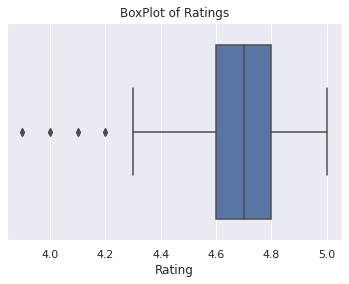

In [6]:
sns.boxplot(df.Rating).set(title = 'BoxPlot of Ratings')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'BoxPlot of Reviews')]

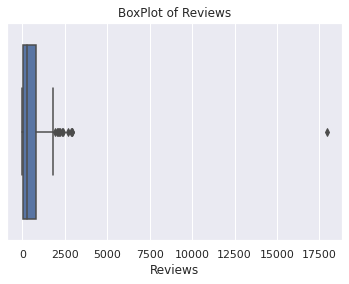

In [7]:
sns.boxplot(df.Reviews).set(title = 'BoxPlot of Reviews')

In [8]:
df.drop(df.Reviews.idxmax() ,inplace = True)

Based on the Boxplots Above both of them have outliers,
but i wont remove the outliers on the ratings column because this is an small dataset and the outliers is still logical
and on the review columns i will only remove the outtest outliers because it's not logical and most likely to be wrong input / irrelevant to the rest of dataset

# Check for NULL Value in Rating

In [9]:
df.loc[df['Rating'].isnull()]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
49,Kherson,Кофе В Херсоне,Cafe,NaN,NaN,NaN,False,NaN,NaN
186,Dnipro,"Coffee&Cake, Game zone PS4",Coffee shop,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.dropna(subset = ['Rating'], inplace = True)

Based on the table above we can see that those 2 rows contains a lot of missing information, so we will drop them

# Check for Unique Value in Dine in option and Takeout option

In [11]:
df['Dine in option'].unique()

array([nan, True], dtype=object)

In [12]:
df['Takeout option'].unique()

array([nan, True], dtype=object)

In [13]:
df['Dine in option'].fillna(False, inplace = True)
df['Takeout option'].fillna(False, inplace = True)

On the data Description nan means False, so i will replace nan to False

# Price and Delivery Options

In [14]:
df['Price'].unique()

array([nan, '$$', '$', '$$$'], dtype=object)

In [15]:
df.Price = df.Price.str.replace('$','s') # Replace $ to s for visualization purposes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Count of Each element in Price')]

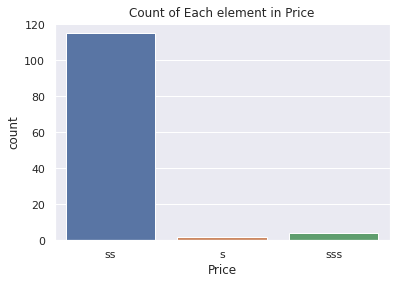

In [16]:
sns.countplot(df['Price']).set(title = 'Count of Each element in Price')

In [17]:
df['Delivery option'].unique()

array([nan, False, True], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Count of Each element in Delivery option')]

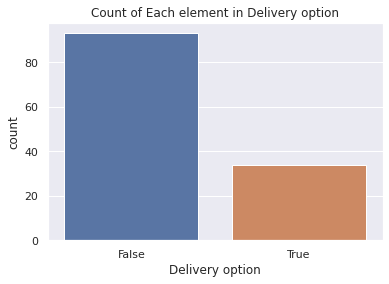

In [18]:
sns.countplot(df['Delivery option']).set(title = 'Count of Each element in Delivery option')

As we can see on the countplot that the data is imbalance, and there is nan value in those columns so if we impute using mode, there will be more data imbalance, therefore i will use KNN to impute the missing data

In [19]:
df.drop(columns = ['Place name'], inplace = True, axis = 0) # Place name doesn't contain relevant information for clustering

# Data Analysis

In [20]:
np.sort(df['Region'].unique())

array(['Dnipro', 'Kharkiv', 'Kherson', 'Khrivoy Rog', 'Kiev', 'Lviv',
       'Mariupol', 'Odessa', 'Poltava', 'Zaporozhye'], dtype=object)

[Text(0, 0.5, 'Average Rating'),
 Text(0.5, 0, 'Region'),
 Text(0.5, 1.0, 'Average Rating of each region')]

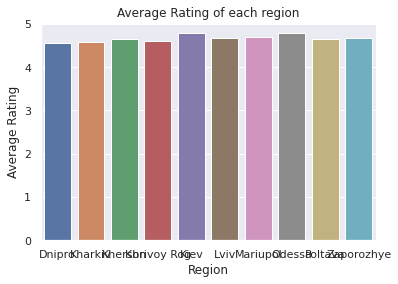

In [21]:
sns.barplot(x = np.sort(df['Region'].unique()), y = np.array(df.groupby('Region').mean()['Rating'])).set(title = 'Average Rating of each region', xlabel = 'Region', ylabel = 'Average Rating')

In [22]:
df.groupby('Region').mean()['Rating'].sort_values(ascending = False)

Region
Odessa         4.785000
Kiev           4.785000
Mariupol       4.700000
Zaporozhye     4.670000
Lviv           4.668421
Poltava        4.655000
Kherson        4.642105
Khrivoy Rog    4.600000
Kharkiv        4.575000
Dnipro         4.547368
Name: Rating, dtype: float64

[Text(0, 0.5, 'Average Reviews'),
 Text(0.5, 0, 'Region'),
 Text(0.5, 1.0, 'Average Reviews of each region')]

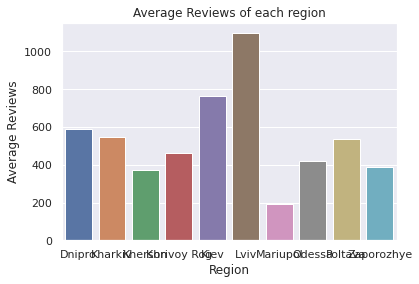

In [23]:
sns.barplot(x = np.sort(df['Region'].unique()), y = np.array(df.groupby('Region').mean()['Reviews'])).set(title = 'Average Reviews of each region', xlabel = 'Region', ylabel = 'Average Reviews')

In [24]:
df.groupby('Region').mean()['Reviews'].sort_values(ascending = False)

Region
Lviv           1096.631579
Kiev            764.600000
Dnipro          589.947368
Kharkiv         544.450000
Poltava         535.250000
Khrivoy Rog     461.900000
Odessa          422.000000
Zaporozhye      389.950000
Kherson         370.157895
Mariupol        193.800000
Name: Reviews, dtype: float64

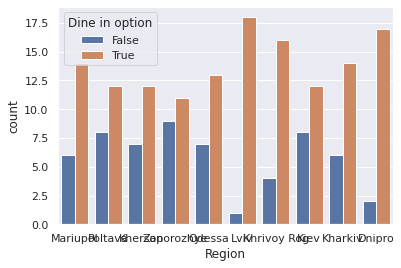

In [25]:
sns.countplot(x = df['Region'], hue = df['Dine in option'])

In [26]:
testdf = df.copy()

# Label Encoding the Categorical Value
Machine can only read numerical values not categorical, so before imputing we will encode the categorical data first

In [27]:
to_encode = ['Region','Place type','Dine in option','Takeout option']
encoder = LabelEncoder()
for i in to_encode:
    df[i] = encoder.fit_transform(df[i])

In [28]:
tempdf = df[['Price','Delivery option']]

In [29]:
df_temp = tempdf.astype("str").apply(LabelEncoder().fit_transform)
df_final = df_temp.where(~tempdf.isna(), tempdf)

In [30]:
df[['Price','Delivery option']] = df_final

In [31]:
df.head()

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,6,6,4.6,206.0,NaN,NaN,0,0
1,6,1,5.0,24.0,2,0,0,1
2,6,4,5.0,11.0,NaN,NaN,0,1
3,6,4,4.4,331.0,2,0,1,1
4,6,4,5.0,12.0,NaN,NaN,1,1


# Impute The missing value using KNNImputer

In [32]:
imputer = KNNImputer()
newdf = imputer.fit_transform(df)

In [33]:
finaldf = pd.DataFrame(newdf,columns = df.columns)
finaldf['Delivery option'] = np.ceil(finaldf['Delivery option'])
# Because Imputer make the data type float so the value is between 0 and 1, so we must ceil the number more than zero to one

In [34]:
finaldf.head()

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,6.0,6.0,4.6,206.0,2.0,1.0,0.0,0.0
1,6.0,1.0,5.0,24.0,2.0,0.0,0.0,1.0
2,6.0,4.0,5.0,11.0,2.0,0.0,0.0,1.0
3,6.0,4.0,4.4,331.0,2.0,0.0,1.0,1.0
4,6.0,4.0,5.0,12.0,2.0,0.0,1.0,1.0


# We will use KNN as the model, and we will use elbow curve to determine the most optimal K 

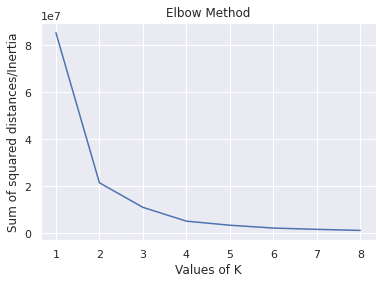

In [35]:
inertia = []
for num_clusters in range(1,9) :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(finaldf)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,9),inertia)
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method')
plt.show()

# Based on the elbow Curves the most optimal K is 4, so i will use 4 as k in the Kmeans

In [36]:
model = KMeans(n_clusters = 4, random_state = 42)
model.fit(finaldf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'scatter of reviews and rating')]

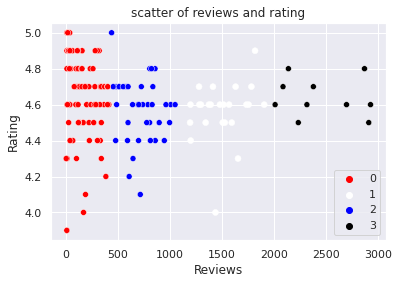

In [37]:
sns.scatterplot(finaldf.Reviews, finaldf.Rating, hue = model.predict(finaldf), palette = 'flag').set(title = 'scatter of reviews and rating')

# With The clustering prediction we can check the feature importance using RandomForest, and set the predicted cluster as the label

In [38]:
from sklearn.ensemble import RandomForestClassifier
X, y = finaldf, model.predict(finaldf)
clf = RandomForestClassifier(n_estimators=100).fit(X, y)

In [39]:
featureimportance = pd.DataFrame(columns = ['Feature','Importance'])
featureimportance['Feature'] = finaldf.columns
featureimportance['Importance'] = clf.feature_importances_
featureimportance

,Feature,Importance
0,Region,0.069702
1,Place type,0.039436
2,Rating,0.088602
3,Reviews,0.690553
4,Price,0.016734
5,Delivery option,0.023119
6,Dine in option,0.045813
7,Takeout option,0.026041


[Text(0.5, 1.0, 'Feature Importance of each Feature')]

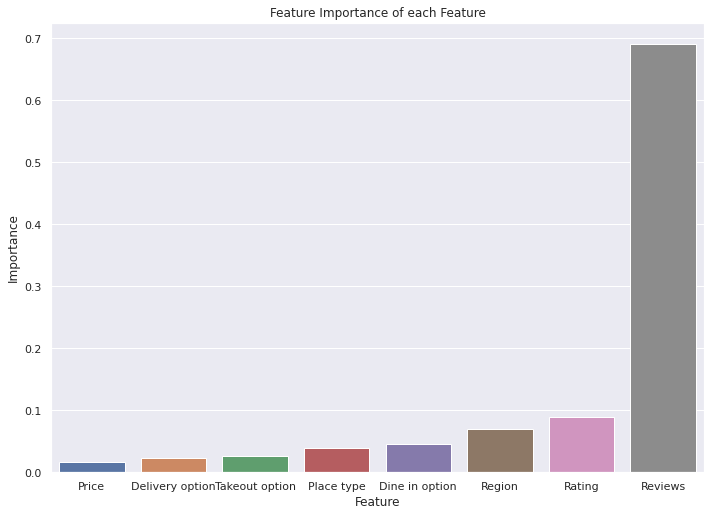

In [40]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = featureimportance['Feature'], y = featureimportance['Importance'],  order=featureimportance.sort_values('Importance').Feature).set(title = 'Feature Importance of each Feature')

In [41]:
featureimportance[featureimportance['Importance'] >= 0.05]

,Feature,Importance
0,Region,0.069702
2,Rating,0.088602
3,Reviews,0.690553


# Based on the Feature Importance Above, we can conclude That the key Features is Reviews, Rating, Region, and Dining Option with a treshold of feature importance above 0.05

In [42]:
column_name_key = featureimportance[featureimportance['Importance'] >= 0.05].Feature.values

In [43]:
testdf['Cluster'] = model.predict(finaldf)

# Data Analysis 2

# Now We will see the count of each cluster of each element of columns with high feature importance

<Figure size 1440x1296 with 0 Axes>

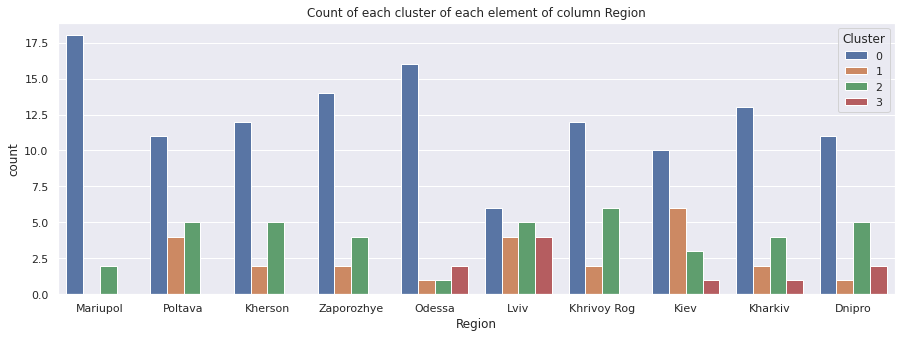

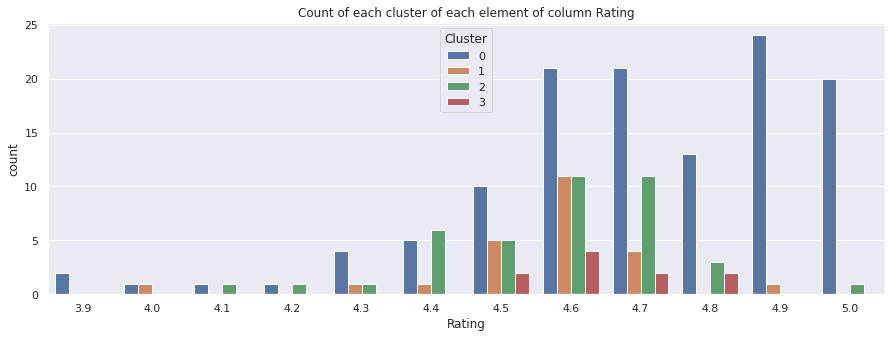

In [44]:
fig = plt.figure(figsize=(20, 18))
x = 1
for i in column_name_key:
    if i == 'Reviews':
        continue
    plt.subplots(figsize = (15,5))
    sns.countplot(x=testdf[i],hue=testdf['Cluster'])
    plt.title('Count of each cluster of each element of column {}'.format(i))
    plt.show()
    x += 1

# LVIV

# Cluster 0

In [45]:
testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 0)]

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
107,Lviv,Coffee shop,4.3,102.0,NaN,NaN,True,True,0
111,Lviv,Coffee shop,5.0,24.0,NaN,True,True,True,0
112,Lviv,Coffee shop,4.7,363.0,ss,False,True,True,0
116,Lviv,Cafe,5.0,10.0,NaN,NaN,False,True,0
118,Lviv,Cafe,4.9,157.0,ss,False,True,True,0
119,Lviv,Coffee shop,4.9,321.0,ss,False,True,True,0


In [46]:
print(testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 0)].mean())

Rating               4.800000
Reviews            162.833333
Delivery option      0.250000
Dine in option       0.833333
Takeout option       1.000000
Cluster              0.000000
dtype: float64


# Cluster 1

In [47]:
testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 1)]

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
104,Lviv,Coffee shop,4.6,1517.0,ss,False,True,True,1
113,Lviv,Coffee roasters,4.6,1199.0,NaN,False,True,True,1
114,Lviv,Coffee shop,4.6,1284.0,ss,False,True,True,1
115,Lviv,Cafe,4.6,1570.0,ss,True,True,True,1


In [48]:
print(testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 1)].mean())

Rating                4.60
Reviews            1392.50
Delivery option       0.25
Dine in option        1.00
Takeout option        1.00
Cluster               1.00
dtype: float64


# Cluster 2

In [49]:
testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 2)]

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
103,Lviv,Coffee shop,4.4,813.0,ss,False,True,True,2
105,Lviv,Coffee shop,4.8,858.0,ss,NaN,True,True,2
106,Lviv,Coffee shop,4.6,702.0,ss,False,True,True,2
108,Lviv,Coffee shop,4.5,778.0,ss,False,True,True,2
109,Lviv,Coffee shop,4.6,1009.0,ss,False,True,True,2


In [50]:
print(testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 2)].mean())

Rating               4.58
Reviews            832.00
Delivery option      0.00
Dine in option       1.00
Takeout option       1.00
Cluster              2.00
dtype: float64


# Cluster 3

In [51]:
testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 3)]

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
101,Lviv,Coffee shop,4.6,2931.0,ss,NaN,True,True,3
102,Lviv,Coffee shop,4.7,2089.0,ss,False,True,True,3
110,Lviv,Coffee shop,4.8,2873.0,ss,False,True,True,3
117,Lviv,Cafe,4.5,2236.0,ss,False,True,True,3


In [52]:
print(testdf.loc[(testdf['Region'] == 'Lviv') & (testdf['Cluster'] == 3)].mean())

Rating                4.65
Reviews            2532.25
Delivery option       0.00
Dine in option        1.00
Takeout option        1.00
Cluster               3.00
dtype: float64


In [53]:
finaldf['cluster'] = model.predict(finaldf)

In [54]:
finaldf.loc[finaldf['Region'] == 5].corr()['cluster'].abs().sort_values(ascending = False)

cluster            1.000000
Reviews            0.823799
Rating             0.343200
Dine in option     0.284497
Place type         0.182815
Delivery option    0.167812
Price              0.076595
Region                  NaN
Takeout option          NaN
Name: cluster, dtype: float64

# Testing Hypothesis

In [55]:
testdataframe = pd.DataFrame([[5,1,3,1500,1,0,1,0],[2,2,5,100,2,1,0,0],[4,3,1,500,2,1,1,1],[5,3,5,10000,4,1,0,1]],columns = df.columns)

In [56]:
testdataframe

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,5,1,3,1500,1,0,1,0
1,2,2,5,100,2,1,0,0
2,4,3,1,500,2,1,1,1
3,5,3,5,10000,4,1,0,1


In [57]:
testdataframe['cluster'] = model.predict(testdataframe)

In [58]:
testdataframe

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,cluster
0,5,1,3,1500,1,0,1,0,1
1,2,2,5,100,2,1,0,0,0
2,4,3,1,500,2,1,1,1,2
3,5,3,5,10000,4,1,0,1,3


# Conclusion
- In This New Market There are 4 Segmentations of Coffe Shops in Ukraine 
- The Key Features Are Reviews, Rating, Region, and Dining Option
- The Most Common Segment is segment 0
-  In LVIV, the segment is well distributed evenly , and in mariupol the cluster is imbalance, as what I said earlier that this statement is caused because number of reviews is highly contributed to distribution of the cluster the higher the review number its more likely for cluster to be distributed evenly.

# Future Work
- Reviews and Ratings is the most important Feature to determine segment, so to adjust the segment the coffee shop need to add more reviews and adjust the rating
- To do that we can use promotions such as giving discounts, if the customer create add a review to our shops


# Thank You